In [144]:
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from tensorflow import keras
from keras.layers import Dense, Input
from keras.models import Model
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

In [4]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2023-06-12 03:05:13--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M  3.65MB/s    in 0.9s    

2023-06-12 03:05:15 (3.65 MB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [121]:
np.random.seed(0)
tf.random.set_seed(0)

In [122]:
df = pd.read_csv("AirlineTweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [123]:
df = df[["airline_sentiment", "text"]]

<Axes: >

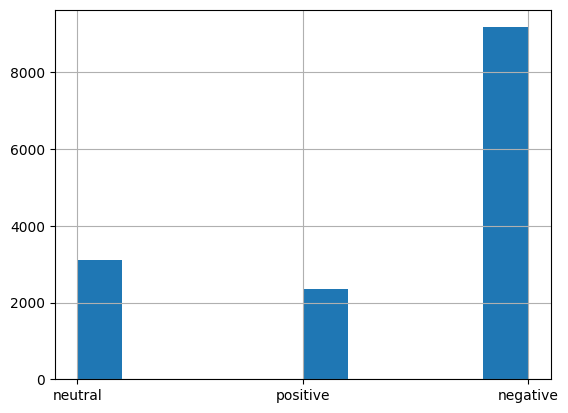

In [124]:
df["airline_sentiment"].hist()

In [125]:
df = df[df["airline_sentiment"] != "neutral"].copy()

<Axes: >

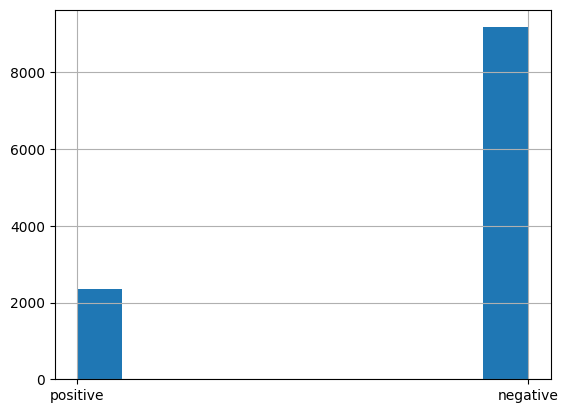

In [126]:
df["airline_sentiment"].hist()

In [127]:
target_map = {"positive":1, "negative":0}
df["target"] = df["airline_sentiment"].map(target_map)

In [12]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [128]:
df_train, df_test = train_test_split(df, random_state=42)

In [129]:
vectorizer = TfidfVectorizer(max_features=2000)
X_train = vectorizer.fit_transform(df_train["text"])
X_test = vectorizer.transform(df_test["text"])

In [130]:
# data must not be sparse matrix before passing into tensorflow
X_train = X_train.toarray()
X_test = X_test.toarray()

In [131]:
Y_train = df_train["target"]
Y_test = df_test["target"]

In [132]:
# input dimension
# X_train = X_train.reshape(X_train.shape[1], X_train.shape[0])
D = X_train.shape[1]

In [133]:
X_train.shape

(8655, 2000)

In [134]:
Y_train.shape

(8655,)

In [135]:
# build model
i = Input(shape=(D,))
x = Dense(1)(i) # sigmoid included in loss

model =Model(i, x)

In [136]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 2000)]            0         
                                                                 
 dense_8 (Dense)             (None, 1)                 2001      
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [137]:
model.compile(
    loss=BinaryCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.01),
    metrics=["accuracy"]
)

In [140]:
(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

((8655, 2000), (8655,), (2886, 2000), (2886,))

In [141]:
r = model.fit(
    x=X_train, y=Y_train,
    validation_data=(X_test, Y_test),
    epochs=40,
    batch_size=256,
)

Epoch 1/40
34/34 [==============================] - 1s 10ms/step - loss: 0.5561 - accuracy: 0.7920 - val_loss: 0.4479 - val_accuracy: 0.8049
Epoch 2/40
34/34 [==============================] - 0s 5ms/step - loss: 0.4235 - accuracy: 0.7921 - val_loss: 0.3848 - val_accuracy: 0.8053
Epoch 3/40
34/34 [==============================] - 0s 6ms/step - loss: 0.3749 - accuracy: 0.7961 - val_loss: 0.3504 - val_accuracy: 0.8174
Epoch 4/40
34/34 [==============================] - 0s 6ms/step - loss: 0.3401 - accuracy: 0.8061 - val_loss: 0.3243 - val_accuracy: 0.8292
Epoch 5/40
34/34 [==============================] - 0s 4ms/step - loss: 0.3122 - accuracy: 0.8237 - val_loss: 0.3035 - val_accuracy: 0.8399
Epoch 6/40
34/34 [==============================] - 0s 4ms/step - loss: 0.2895 - accuracy: 0.8417 - val_loss: 0.2871 - val_accuracy: 0.8527
Epoch 7/40
34/34 [==============================] - 0s 6ms/step - loss: 0.2710 - accuracy: 0.8540 - val_loss: 0.2735 - val_accuracy: 0.8652
Epoch 8/40
34/34 [=

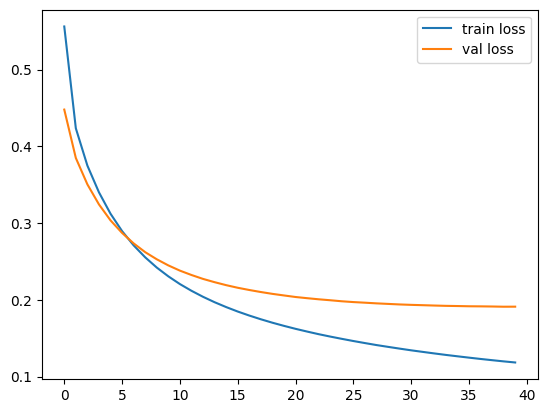

In [145]:
# Plot loss per iteration
plt.plot(r.history["loss"], label="train loss")
plt.plot(r.history["val_loss"], label="val loss")
plt.legend();

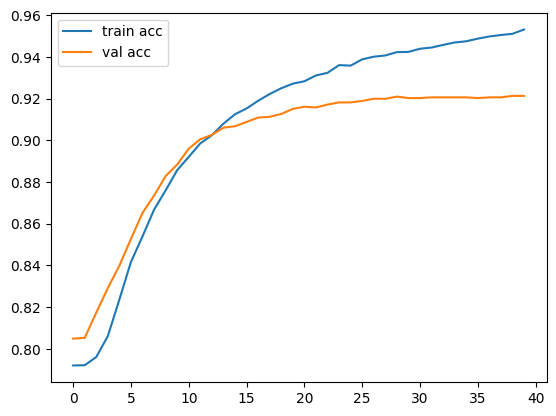

In [146]:
# Plot accuracy per iteration
plt.plot(r.history["accuracy"], label="train acc")
plt.plot(r.history["val_accuracy"], label="val acc")
plt.legend();

In [148]:
len(r.history)

4

In [149]:
P_train = ((model.predict(X_train) > 0) * 1.0).flatten()
P_test = ((model.predict(X_test) > 0) * 1.0).flatten()

91/91 [==============================] - 0s 2ms/step


In [150]:
cm = confusion_matrix(Y_train, P_train, normalize="true")
cm

array([[0.9889132 , 0.0110868 ],
       [0.12611111, 0.87388889]])

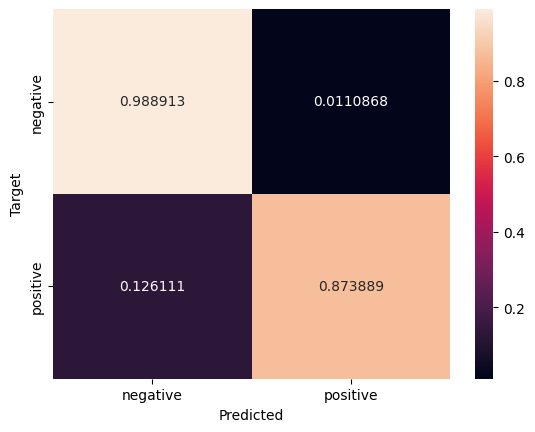

In [152]:
def plot_cm(cm):
    classes = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt="g")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

plot_cm(cm)

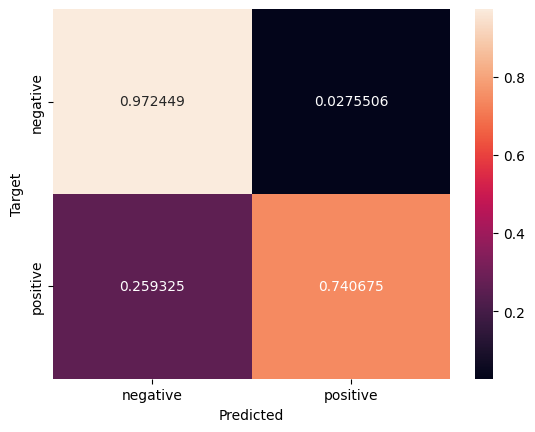

In [154]:
cm_test = confusion_matrix(Y_test, P_test, normalize="true")
plot_cm(cm_test)

In [156]:
Pr_train = model.predict(X_train)
Pr_test = model.predict(X_test)
print("Train AUC:", roc_auc_score(Y_train, Pr_train))
print("Test AUC:", roc_auc_score(Y_test, Pr_test))

91/91 [==============================] - 0s 3ms/step
Train AUC: 0.9923850393062646
Test AUC: 0.9565691452147764


In [157]:
print("Train F1:", f1_score(Y_train, P_train))
print("Test F1:", f1_score(Y_test, P_test))

Train F1: 0.9121484488257467
Test F1: 0.7988505747126438


In [158]:
model.layers

In [159]:
model.layers[1].get_weights()

[array([[-2.9689002],
        [ 2.449272 ],
        [-1.4078522],
        ...,
        [ 1.6173928],
        [ 1.0926547],
        [-2.4488578]], dtype=float32),
 array([-0.26583022], dtype=float32)]

In [161]:
w = model.layers[1].get_weights()[0]

In [163]:
word_index_map = vectorizer.vocabulary_
word_index_map

{'jetblue': 973,
 'thanks': 1726,
 'for': 753,
 'having': 855,
 'us': 1859,
 'hang': 838,
 'out': 1262,
 'at': 197,
 'tampa': 1708,
 'airport': 122,
 'forever': 756,
 'today': 1767,
 'it': 964,
 'really': 1420,
 'been': 243,
 'an': 147,
 'awesome': 217,
 'experience': 654,
 'americanair': 143,
 'was': 1898,
 'told': 1770,
 'you': 1993,
 'could': 452,
 'only': 1245,
 'refund': 1434,
 'me': 1107,
 'the': 1730,
 'cost': 448,
 'of': 1224,
 'my': 1179,
 'original': 1254,
 'return': 1476,
 'flight': 726,
 'note': 1211,
 'had': 828,
 'booked': 273,
 'more': 1164,
 'expensive': 653,
 'everyone': 635,
 'else': 602,
 'outstanding': 1267,
 'united': 1842,
 'denver': 516,
 'to': 1766,
 'austin': 207,
 'still': 1660,
 'on': 1239,
 'ground': 820,
 'issue': 961,
 'is': 959,
 'lack': 999,
 'announcement': 151,
 'made': 1086,
 'so': 1606,
 'late': 1010,
 'when': 1929,
 'gate': 793,
 'agent': 113,
 'there': 1734,
 'over': 1268,
 'hour': 897,
 'southwestair': 1626,
 'hold': 880,
 '30': 36,
 'min': 1141,


In [164]:
threshold = 2

print("Most positive words:")
word_weight_tuples = []
for word, index in word_index_map.items():
  weight = w[index, 0]
  if weight > threshold:
    word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: -x[1])
for i in range(10):
  word, weight = word_weight_tuples[i]
  print(word, weight)

Most positive words:
thanks 6.535521
thank 6.3992033
worries 5.9656773
great 5.936234
awesome 5.464704
love 5.281
amazing 5.1814203
excellent 5.135967
kudos 5.0001287
best 4.8902245


In [165]:
print("Most megative words:")
word_weight_tuples = []
for word, index in word_index_map.items():
  weight = w[index, 0]
  if weight < -threshold:
    word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: x[1])
for i in range(10):
  word, weight = word_weight_tuples[i]
  print(word, weight)

Most megative words:
worst -6.0600405
paid -5.3769083
not -5.3104014
nothing -5.040068
rude -4.9825945
website -4.966253
disappointed -4.822226
failed -4.55145
terrible -4.4791594
hung -4.430782
